In [201]:
from datetime import date, datetime, timedelta
from binance.binance_k_line_repository import load_k_lines
import pandas as pd
from numpy import float16, float64


In [202]:
interval_date_from = date(2023, 5, 1)
interval_date_to = date(2023, 5, 31)
symbol: str = "ETHUSDT"

raw_k_lines = load_k_lines(symbol, interval_date_from, interval_date_to)

display(raw_k_lines)

,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1682899200000,1868.41,1871.06,1867.20,1869.44,20316.217,1682899259999,3.797542e+07,11692,11552.083,2.159521e+07,0
1,1682899260000,1869.44,1875.64,1869.34,1875.63,19738.657,1682899319999,3.698278e+07,10552,12767.284,2.391795e+07,0
2,1682899320000,1875.64,1875.64,1872.80,1872.80,12220.644,1682899379999,2.290880e+07,6146,4005.436,7.507829e+06,0
3,1682899380000,1872.81,1877.26,1872.55,1877.26,7275.710,1682899439999,1.364297e+07,6926,5023.121,9.419046e+06,0
4,1682899440000,1877.26,1881.39,1876.84,1880.40,14390.501,1682899499999,2.704258e+07,9779,9616.647,1.807247e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1685577300000,1873.17,1874.41,1873.08,1874.41,4202.478,1685577359999,7.873024e+06,1590,2667.404,4.997601e+06,0
1436,1685577360000,1874.40,1874.41,1872.54,1872.80,3444.416,1685577419999,6.454170e+06,1565,401.812,7.527455e+05,0
1437,1685577420000,1872.81,1873.44,1872.64,1872.84,1423.699,1685577479999,2.666499e+06,1428,820.822,1.537314e+06,0
1438,1685577480000,1872.84,1872.95,1872.53,1872.83,820.012,1685577539999,1.535584e+06,910,353.406,6.618053e+05,0


In [203]:
k_lines = raw_k_lines[[
    # "open_price"    , 
    # "low_price", 
    # "high_price", 
    "close_price", 
    # "volume", 
    # "trades_count"
    ]]
k_lines.index = pd.to_datetime(raw_k_lines["open_timestamp_millis"], unit="ms")
k_lines.index.name = "open_datetime"

k_lines

,close_price
open_datetime,
2023-05-01 00:00:00,1869.44
2023-05-01 00:01:00,1875.63
2023-05-01 00:02:00,1872.80
2023-05-01 00:03:00,1877.26
2023-05-01 00:04:00,1880.40
...,...
2023-05-31 23:55:00,1874.41
2023-05-31 23:56:00,1872.80
2023-05-31 23:57:00,1872.84


In [204]:
interval_minutes = ((interval_date_to - interval_date_from).days + 1) * 24 * 60

assert len(k_lines) == interval_minutes

assert len(k_lines[k_lines.isna().any(axis=1)]) == 0
assert len(k_lines[k_lines.isnull().any(axis=1)]) == 0

assert k_lines.dtypes["close_price"] == float64
assert len(k_lines[k_lines["close_price"] <= 0]) == 0

assert (
    (k_lines.index.to_series() - k_lines.index.to_series().shift(1))
    .iloc[1:]
    .dt.total_seconds()
    == 60
).all()

<Axes: xlabel='open_datetime'>

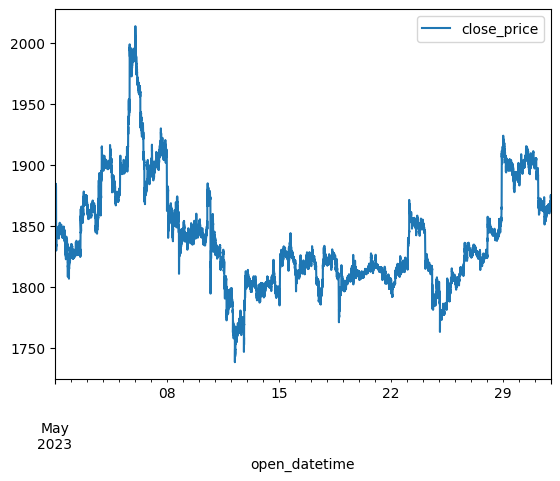

In [205]:
k_lines.plot.line(use_index=True)

In [206]:
features = k_lines[k_lines.columns]

window_minutes = 240

features["mean_close_price"] = (
    features["close_price"].shift(1).rolling(window_minutes).mean()
)
features["past_close_price"] = features["close_price"].shift(window_minutes)
features["future_close_price"] = features["close_price"].shift(-window_minutes)

features["mean_close_price_ratio"] = (
    features["close_price"] / features["mean_close_price"]
)
features["past_close_price_ratio"] = (
    features["close_price"] / features["past_close_price"]
)
features["future_close_price_ratio"] = (
    features["future_close_price"] / features["close_price"]
)

features.dropna(inplace=True)

display(features)

,close_price,mean_close_price,past_close_price,future_close_price,mean_close_price_ratio,past_close_price_ratio,future_close_price_ratio
open_datetime,,,,,,,
2023-05-01 04:00:00,1845.20,1858.589792,1869.44,1847.87,0.992796,0.987034,1.001447
2023-05-01 04:01:00,1843.43,1858.488792,1875.63,1847.74,0.991897,0.982832,1.002338
2023-05-01 04:02:00,1843.69,1858.354625,1872.80,1847.32,0.992109,0.984456,1.001969
2023-05-01 04:03:00,1842.85,1858.233333,1877.26,1847.73,0.991722,0.981670,1.002648
2023-05-01 04:04:00,1842.39,1858.089958,1880.40,1847.51,0.991550,0.979786,1.002779
...,...,...,...,...,...,...,...
2023-05-31 19:55:00,1864.73,1862.233208,1858.14,1874.41,1.001341,1.003547,1.005191
2023-05-31 19:56:00,1864.30,1862.260667,1857.50,1872.80,1.001095,1.003661,1.004559
2023-05-31 19:57:00,1864.38,1862.289000,1856.68,1872.84,1.001123,1.004147,1.004538


<Axes: xlabel='close_price', ylabel='future_close_price'>

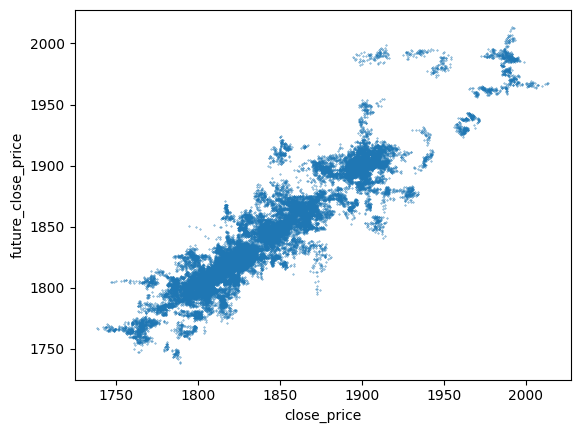

In [207]:
features.plot.scatter(x="close_price", y="future_close_price", s=0.1)

<Axes: ylabel='Frequency'>

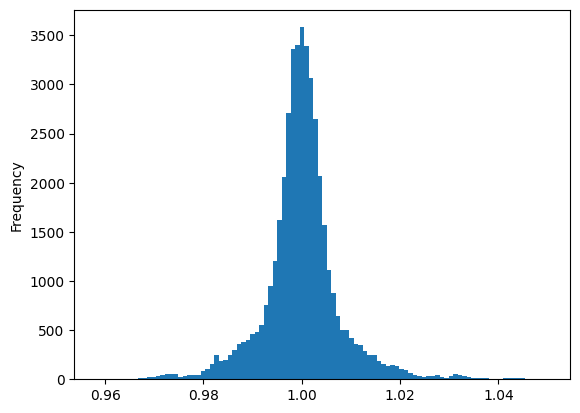

In [208]:
features["future_close_price_ratio"].plot.hist(bins=100)

<Axes: xlabel='close_price', ylabel='future_close_price_ratio'>

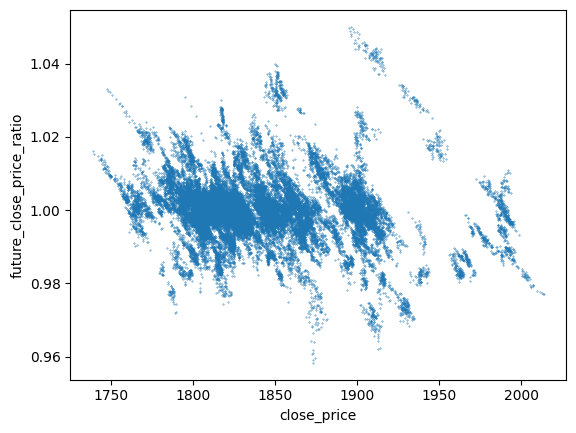

In [209]:
features.plot.scatter(x="close_price", y="future_close_price_ratio", s=0.1)

<Axes: xlabel='mean_close_price_ratio', ylabel='future_close_price_ratio'>

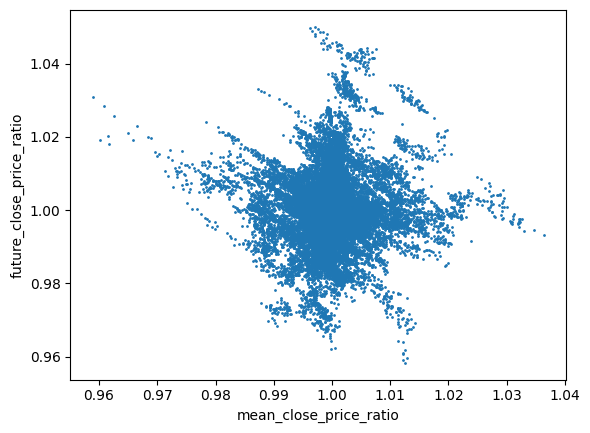

In [211]:
features.plot.scatter(x="mean_close_price_ratio", y="future_close_price_ratio", s=1)

<Axes: xlabel='past_close_price_ratio', ylabel='future_close_price_ratio'>

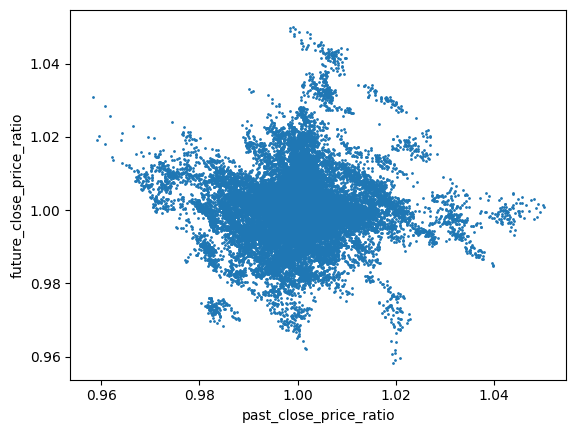

In [212]:
features.plot.scatter(x="past_close_price_ratio", y="future_close_price_ratio", s=1)